In [32]:
# version 2.0
# ugbio_methylation.methyldackel_qc_report.ipynb
# =============================================


In [33]:
# from IPython.display import display, HTML

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display  # noqa:A004

In [34]:
import warnings

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

warnings.filterwarnings("ignore")

In [35]:
pd.set_option("display.max_rows", 10000)
pd.set_option("display.width", 1200)
pd.set_option("display.max_colwidth", 0)

In [36]:
input_h5_file = ""
input_base_file_name = ""

In [37]:
# seperate the processing into the different tables from MethylDackel
with pd.HDFStore(input_h5_file, "r") as store:
    list_tables = store.keys()

In [38]:
def format_metric_names(df_in):
    df_in["metric"] = df_in["metric"].str.replace(r"PercentMethylation", "Percent Methylation: ", regex=True)
    df_in["metric"] = df_in["metric"].str.replace(
        r"PercentMethylationPosition", "Percent Methylation Position: ", regex=True
    )
    df_in["metric"] = df_in["metric"].str.replace(r"CumulativeCoverage", "Cumulative Coverage", regex=True)
    df_in["metric"] = df_in["metric"].str.replace(r"Coverage", "Coverage: ", regex=True)
    df_in["metric"] = df_in["metric"].str.replace(r"TotalCpGs", "Total CpGs: ", regex=True)
    df_in["metric"] = df_in["metric"].str.replace(r"_", " ", regex=True)
    return df_in

In [39]:
def parse_metric_names(df_in):
    df_in["metric_orig"] = df_in["metric"]
    pat = r"\w+_(\d+)"  # get value of bins
    df_in["bin"] = df_in["metric"].str.extract(pat)
    # get metric name
    pat = r"(\w+)_\d+"
    df_in["metric"] = df_in["metric"].str.extract(pat)
    return df_in

In [40]:
def display_side_by_side(dfs: list, captions: list, tablespacing=2):
    output = ""
    for caption, df in zip(captions, dfs, strict=False):
        output += df.style.set_table_attributes("style='display:inline-table'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"

    display(HTML(output))

# QC Report for Methylation Calling
## Input parameters

In [41]:
to_print_sample_info = pd.DataFrame(
    data={"value": [input_base_file_name, str(input_h5_file)]}, index=["Sample name", "h5 file"]
)

to_print_sample_info["value"] = to_print_sample_info["value"].str.wrap(100)


def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n", "<br>")))


wrap_df_text(to_print_sample_info.style.set_properties(**{"text-align": "left"}))

,value
Sample name,test
h5 file,/workspaces/ugbio-utils/test.methyl_seq.applicationQC.h5


## Human Genome: Global Methylation Statistics

In [42]:
# main statistics table
# --------------------------
tbl = "merge_context_desc"
genome = "hg"
df_desc = pd.read_hdf(input_h5_file, key=tbl)
df_desc = pd.DataFrame(df_desc)
df_desc = df_desc.query("detail == @genome")
df_desc = df_desc.reset_index()
df_desc = df_desc.drop(columns=["detail"])
df_desc = format_metric_names(df_desc)
to_int = df_desc.metric == "Total CpGs: "
to_float = df_desc.metric != "Total CpGs: "
df_desc.loc[to_int, "value"] = df_desc.loc[to_int, "value"].map("{:,.0f}".format)
df_desc.loc[to_float, "value"] = df_desc.loc[to_float, "value"].map("{:,.2f}".format)
display(df_desc.set_index("metric"))

# -----------

,value
metric,
Percent Methylation: mean,75.69
Percent Methylation: std,26.33
Percent Methylation: median,85.00
Total CpGs:,"4,999"
Coverage: mean,34.86
Coverage: std,37.43
Coverage: median,25.00


## Human Genome: Details of Per-Read Descriptive Statistics

In [43]:
# per Read information
# ------------------------

tbl = "per_read_desc"
genome = "hg"
df_desc = pd.read_hdf(input_h5_file, key=tbl)
df_desc = pd.DataFrame(df_desc)
df_desc = df_desc.reset_index()
df_desc = df_desc.drop(columns=["detail"])
df_desc = format_metric_names(df_desc)
df_desc["value"] = df_desc["value"].map("{:,.2f}".format)
display(df_desc.set_index("metric"))

# -----------

,value
metric,
Percent Methylation: mean,44.45
Percent Methylation: std,44.02
Percent Methylation: median,33.33
Total CpGs: mean,5.92
Total CpGs: std,9.13
Total CpGs: median,2.00


## Human Genome: Cytosines in Other Contexts Descriptive Statistics

In [44]:
tbl = "merge_context_non_cpg_desc"

df_desc = pd.read_hdf(input_h5_file, key=tbl)
df_desc = pd.DataFrame(df_desc)
df_desc = df_desc.reset_index()
df_desc = format_metric_names(df_desc)

df_desc["stat_type"] = df_desc["metric"].str.extract(r"([A-Za-z]+)[\s:]")
df_desc["metric"] = df_desc["metric"].str.title()
df_desc["value"][df_desc["stat_type"] == "Percent"] = (df_desc["value"][df_desc["stat_type"] == "Percent"] / 100).map(
    "{:,.2%}".format
)
df_desc["value"][df_desc["stat_type"] == "Coverage"] = df_desc["value"][df_desc["stat_type"] == "Coverage"].map(
    "{:,.2f}".format
)

table_names = df_desc["detail"].unique()
df_output = []
df_output = [y for x, y in df_desc.groupby("detail")]

df_to_print = []
for line in df_output:
    line.index = line["metric"]
    line = line["value"].to_frame()  # noqa: PLW2901
    df_to_print.append(line)

display_side_by_side(df_to_print, table_names)

# --------

,value
metric,
Percent Methylation: Mean,1.80%
Percent Methylation: Std,10.82%
Percent Methylation: Median,0.00%
Coverage: Mean,4.72
Coverage: Std,3.61
Coverage: Median,4.00
,value
metric,
Percent Methylation: Mean,2.68%


In [45]:
# function for creating Mbias plots
# -----------------------------------------------------------------------------------
def plot_mbias(in_list_df):
    plt.style.use("ggplot")

    if len(in_list_df) == 4:  # noqa: PLR2004
        i = j = k = 0
        in_colours = ["tomato", "indianred", "tomato", "indianred"]
        f, ax = plt.subplots(2, 2, figsize=[12, 12])

        for j in range(ax.shape[0]):
            for k in range(ax.shape[1]):
                currax = ax[j][k]
                curr_title = in_list_df[i]["detail"].unique()[0]

                sns.lineplot(data=in_list_df[i], x="bin", y="value", lw=2.5, ax=currax, color=in_colours[i])
                currax.set_xlabel("Position", fontsize=14)
                currax.set_ylabel("Fraction of Methylation", fontsize=14)
                currax.set_title(curr_title, fontsize=14)
                currax.tick_params(labelsize=14)
                plt.xticks(rotation=45)
                currax.set_ylim([0, 1])
                i += 1

        plt.tight_layout()

    else:
        in_colours = ["tomato", "indianred"]
        f, ax = plt.subplots(1, 2, figsize=[12, 5.5])

        for i in range(len(in_list_df)):
            currax = ax[i]
            curr_title = in_list_df[i]["detail"].unique()[0]

            sns.lineplot(data=in_list_df[i], x="bin", y="value", lw=2.5, ax=currax, color=in_colours[i])
            currax.set_xlabel("Position", fontsize=14)
            currax.set_ylabel("Fraction of Methylation", fontsize=14)
            currax.set_title(list_tables[i], fontsize=14)
            currax.tick_params(labelsize=14)
            plt.xticks(rotation=45)
            currax.set_ylim([0, 1])

        plt.tight_layout()


# --------

## Human Genome: M-bias plots of mean methylation along reads

In [47]:
# Mbias: Mean methylation along reads
# ========================================

tbl = "mbias_per_position"

df_pos = pd.read_hdf(input_h5_file, key=tbl)
df_pos = pd.DataFrame(df_pos)
df_pos = df_pos.reset_index()
df_pos = parse_metric_names(df_pos)
df_pos["bin"] = df_pos["bin"].astype(int)
list_tables = list(set(df_pos["detail"]))

df_to_print = df_pos.copy()
df_to_print["stat_type"] = df_to_print["metric"].str.extract(r"([A-Za-z]+)\s")
df_to_print["metric"] = df_to_print["metric"].str.title()

list_df = [y for x, y in df_to_print.groupby(df_pos["detail"], sort=False)]

# plot the MBIAS tests
plot_mbias(list_df)

# ---------------

KeyboardInterrupt: 

## M-bias Descriptive Statistics

In [23]:
# CONTINUES Mbias: Mean methylation along reads
tbl = "mbias_desc"

df_desc = pd.read_hdf(input_h5_file, key=tbl)
df_desc = pd.DataFrame(df_desc)
df_desc = df_desc.reset_index()
df_desc = format_metric_names(df_desc)

df_to_print = df_desc.copy()
df_to_print["stat_type"] = df_to_print["metric"].str.extract(r"([A-Za-z]+)\s")
df_to_print["metric"] = df_to_print["metric"].str.title()


df_to_print["value"][df_to_print["stat_type"] == "Percent"] = (
    df_to_print["value"][df_to_print["stat_type"] == "Percent"]
).map("{:,.2%}".format)


cols = ["metric", "value"]
df_output = []
df_output = [y for x, y in df_to_print.groupby("detail")]


if len(df_output) == 4:  # noqa: PLR2004
    order = [3, 2, 1, 0]
else:
    order = [1, 0]
df_output = [df_output[i] for i in order]

del df_to_print
df_to_print = []
temp_tables = []
for line in df_output:
    line.index = line["metric"]
    temp_tables.append(line["detail"][0])
    df_to_print.append(line["value"].to_frame())

display_side_by_side(df_to_print, temp_tables)

# ---------------

,value
metric,
Percent Methylation: Mean,48.14%
Percent Methylation: Std,10.81%
Percent Methylation: Median,52.28%
,value
metric,
Percent Methylation: Mean,47.65%
Percent Methylation: Std,13.53%
Percent Methylation: Median,53.98%


## Human Genome: M-bias plots of mean methylation on CHH/CHG along reads

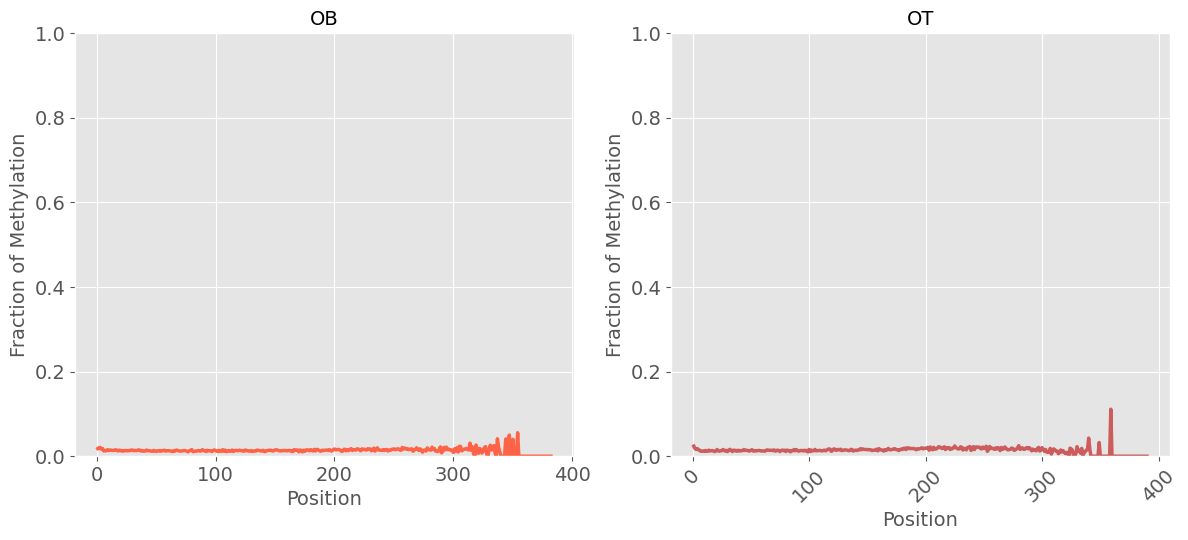

In [24]:
# MbiasNoCpG: Mean methylation along reads on non-CpG Cytosines
# ========================================

tbl = "mbias_non_cpg_per_position"

df_pos = pd.read_hdf(input_h5_file, key=tbl)
df_pos = pd.DataFrame(df_pos)
df_pos = df_pos.reset_index()
df_pos = parse_metric_names(df_pos)
df_pos["bin"] = df_pos["bin"].astype(int)
list_tables = list(set(df_pos["detail"]))

df_to_print = df_pos.copy()
df_to_print["stat_type"] = df_to_print["metric"].str.extract(r"([A-Za-z]+)\s")
df_to_print["metric"] = df_to_print["metric"].str.title()

list_df = [y for x, y in df_to_print.groupby(df_pos["detail"], sort=False)]

# plot the MBIAS tests
plot_mbias(list_df)

# ---------------

## M-bias of CHH/CHG Descriptive Statistics

In [25]:
# CONTINUES MbiasNoCpG: Mean methylation along reads on non-CpG Cytosines
tbl = "mbias_non_cpg_desc"

df_desc = pd.read_hdf(input_h5_file, key=tbl)
df_desc = pd.DataFrame(df_desc)
df_desc = df_desc.reset_index()
df_desc = format_metric_names(df_desc)

df_to_print = df_desc.copy()
df_to_print["stat_type"] = df_to_print["metric"].str.extract(r"([A-Za-z]+)\s")
df_to_print["metric"] = df_to_print["metric"].str.title()


df_to_print["value"][df_to_print["stat_type"] == "Percent"] = (
    df_to_print["value"][df_to_print["stat_type"] == "Percent"]
).map("{:,.2%}".format)


cols = ["metric", "value"]
df_output = []
df_output = [y for x, y in df_to_print.groupby("detail")]


if len(df_output) == 4:  # noqa: PLR2004
    order = [3, 2, 1, 0]
else:
    order = [1, 0]
df_output = [df_output[i] for i in order]

del df_to_print
df_to_print = []
temp_tables = []
for line in df_output:
    line.index = line["metric"]
    temp_tables.append(line["detail"][0])
    df_to_print.append(line["value"].to_frame())

display_side_by_side(df_to_print, temp_tables)

# ---------------

,value
metric,
Percent Methylation: Mean,1.35%
Percent Methylation: Std,0.62%
Percent Methylation: Median,1.35%
,value
metric,
Percent Methylation: Mean,1.40%
Percent Methylation: Std,0.78%
Percent Methylation: Median,1.44%


In [26]:
## Control genomes (if exist)
# ------------------------------

tbl = "merge_context_per_position"
if tbl in list_tables:
    df_pos = pd.read_hdf(input_h5_file, key=tbl)
    df_pos = pd.DataFrame(df_pos)
    df_pos = df_pos.reset_index()
    all_genomes = list(set(df_pos["detail"]))
    ctrl_genomes = ["Lambda", "pUC19"]

    check = all(item in all_genomes for item in ctrl_genomes)

    if check is True:
        display(HTML("<h2>" + "Control Genomes: Methylation and Coverage" + "</h2>"))

        # PRINT PLOTS OF PERCENT METHYLATION ACROSS ENTIRE CONTROL GENOMES
        # -----------------------------------------------------------------

        df_pos = parse_metric_names(df_pos)
        df_pos["bin"] = df_pos["bin"].astype(int)
        df_pos = format_metric_names(df_pos)
        df_pos["bin"] = df_pos["bin"].astype(int)
        df_pos = df_pos.query('metric == "Percent Methylation: Position"')
        df_output = [y for x, y in df_pos.groupby("detail")]

        df_pos_meth = []
        n = 102
        f, ax = plt.subplots(1, 2, figsize=[12, 5])
        i = 0
        palet = ["forestgreen", "steelblue"]

        for df_pos_meth in df_output:
            # get methylation per position
            df_pos_meth = df_pos_meth.reset_index()  # noqa: PLW2901
            temp_genome = df_pos_meth["detail"].unique()[0]

            # print to subplots
            currax = ax[i]
            s = df_pos_meth.plot(
                kind="area",
                ylim=[0, n],
                y="value",
                title=temp_genome + ": Percent methylation",
                legend=False,
                color=palet[i],
                alpha=0.6,
                ax=currax,
                fontsize=14,
            )
            a = currax.set(xlabel="Position", ylabel="Percent Methylation")
            plt.style.use("ggplot")

            i += 1

# --------

In [27]:
## Control genomes (if exist)
# ------------------------------

tbl = "merge_context_desc"
df_desc = pd.read_hdf(input_h5_file, key=tbl)
df_desc = pd.DataFrame(df_desc)
df_desc = df_desc.reset_index()
all_genomes = list(set(df_desc["detail"]))
ctrl_genomes = ["Lambda", "pUC19"]

check = all(item in all_genomes for item in ctrl_genomes)

if check is True:
    display(HTML("<h2>" + "Control Genomes: Methylation and Coverage Descriptive Statistics" + "</h2>"))

    tbl = "merge_context"
    genome = "hg"
    df_to_print = pd.DataFrame()
    df_table = df_desc[df_desc["detail"] != genome]
    df_table = df_table.reset_index()
    df_table = format_metric_names(df_table)

    df_table["stat_type"] = df_table["metric"].str.extract(r"([A-Za-z]+)[\s:]")
    df_table["metric"] = df_table["metric"].str.title()
    df_table["value"][df_table["stat_type"] == "Percent"] = (
        df_table["value"][df_table["stat_type"] == "Percent"] / 100
    ).map("{:,.2%}".format)
    df_table["value"][df_table["stat_type"] == "Coverage"] = df_table["value"][df_table["stat_type"] == "Coverage"].map(
        "{:,.2f}".format
    )
    df_table["value"][df_table["stat_type"] == "Total"] = df_table["value"][df_table["stat_type"] == "Total"].map(
        "{:,.0f}".format
    )
    df_table["metric"] = df_table["metric"].str.replace(r"Cpgs", "CpGs", regex=True)

    table_names = df_table["detail"].unique()
    cols = ["metric", "value", "detail"]
    df_output = []
    df_output = [y for x, y in df_table.groupby("detail")]

    df_to_print = []
    for line in df_output:
        line.index = line["metric"]
        df_to_print.append(line["value"].to_frame())

    display_side_by_side(df_to_print, table_names)

    # --------

,value
metric,
Percent Methylation: Mean,0.12%
Percent Methylation: Std,1.06%
Percent Methylation: Median,0.00%
Total CpGs:,"3,113"
Coverage: Mean,199.53
Coverage: Std,7.05
Coverage: Median,200.00
,value
metric,


In [28]:
# function for printing bar plots of methylation and coverage at CpGs
def plot_bar_distrib(in_table):
    i = 0
    in_colours = ["salmon", "tomato"]
    curr_genome = "Human Genome"
    n_rows = in_table.shape[0]
    if n_rows > 10:  # noqa: PLR2004
        h = 5
        w = 13.5
        n = 2

        in_list_df = [y for x, y in in_table.groupby(in_table["metric"], sort=False)]
        f, ax = plt.subplots(1, n, figsize=[w, h])  # noqa: F821
        # noqa: F821
        for i in range(len(in_list_df)):
            currax = ax[i]
            y_axis_label = in_list_df[i]["metric"].unique()[0]
            y_axis_label = y_axis_label.replace(":", "")
            x_axis_label = "Value Bins"
            curr_title = curr_genome + ": " + y_axis_label

            sns.barplot(data=in_list_df[i], x="bin", y="value", lw=2.5, ax=currax, color=in_colours[i])
            currax.set_xlabel(x_axis_label, fontsize=14)
            currax.set_ylabel(y_axis_label, fontsize=14)
            currax.set_title(curr_title, fontsize=13)
            currax.tick_params(labelsize=14)
            f.axes[i].tick_params(labelrotation=45)

    else:
        h = 5
        w = 5.5
        n = 1

        f, ax = plt.subplots(n, n, figsize=[w, h])

        y_axis_label = in_table["metric"].unique()[0]
        y_axis_label = y_axis_label.replace(":", "")
        curr_title = curr_genome + ": " + y_axis_label

        sns.barplot(data=in_table, x="bin", y="value", lw=2.5, ax=ax, color=in_colours[i])
        ax.set_xlabel("Value Bins", fontsize=14)
        ax.set_ylabel(y_axis_label, fontsize=14)
        ax.set_title(curr_title, fontsize=13)
        ax.tick_params(labelsize=14)
        plt.xticks(rotation=45)


# --------

In [29]:
# print details of mergeCOntext plots of CpG Methylation and Coverage
# -----------------------------
# main statistics table
# --------------------------
tbl = "merge_context_hist"
genome = "hg"
df_hist = pd.read_hdf(input_h5_file, key=tbl)
df_hist = pd.DataFrame(df_hist)
df_hist = df_hist.reset_index()
df_hist = df_hist[df_hist["detail"] == genome]
df_hist = parse_metric_names(df_hist)
df_hist = format_metric_names(df_hist)
df_hist["stat_type"] = df_hist["metric"].str.extract(r"([A-Za-z]+):")

## Human Genome: Additional Details of CpG Methylation and Coverage

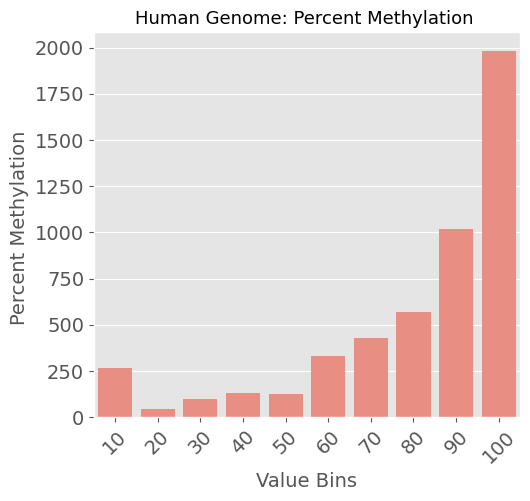

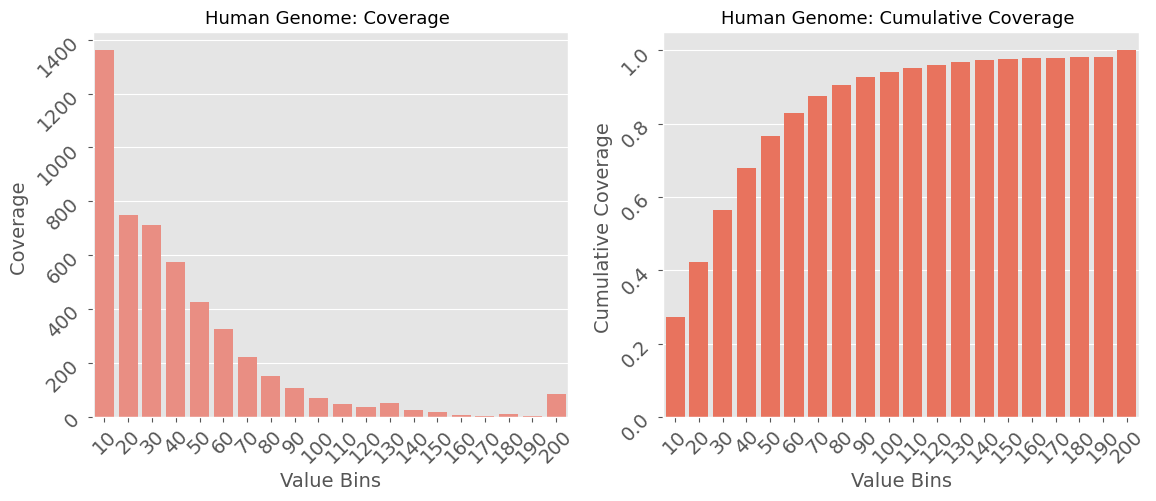

In [30]:
list_df = [y for x, y in df_hist.groupby(df_hist["stat_type"], sort=False)]

for df_to_plot in list_df:
    plot_bar_distrib(df_to_plot)

## Human Genome: Values of CpG Methylation and Coverage

In [31]:
# print details of figures
# --------------------------

list_df = [y for x, y in df_hist.groupby(df_hist["metric"], sort=False)]

df_to_print = []
temp_tables = []
for i, sub_df in enumerate(list_df):
    sub_df = sub_df.reset_index()  # noqa: PLW2901
    if i < 2:  # noqa: PLR2004
        sub_df["value"] = sub_df["value"].map("{:,.0f}".format)
    else:
        sub_df["value"] = sub_df["value"].map("{:,.2%}".format)
    temp_tables.append(sub_df["metric"][0].replace(":", ""))
    sub_df.index = sub_df["bin"]
    df_to_print.append(sub_df["value"].to_frame())


display_side_by_side(df_to_print, temp_tables)
# -------

,value
bin,
10,264
20,45
30,99
40,132
50,126
60,331
70,429
80,572
90,"1,017"
